In [32]:
import pandas as pd

df = pd.read_csv("Ball_by_Ball.csv", delimiter=";")

In [33]:
!pip install scikit-fuzzy

In [34]:
!pip install git+https://github.com/omadson/fuzzy-c-means

  Cloning https://github.com/omadson/fuzzy-c-means to c:\users\acer\appdata\local\temp\pip-req-build-sp192f0k
  Resolved https://github.com/omadson/fuzzy-c-means to commit c119596941d41d92dd2866ab3733af4d7b2d60c4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/omadson/fuzzy-c-means 'C:\Users\acer\AppData\Local\Temp\pip-req-build-sp192f0k'


In [35]:
!pip install seaborn

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fcmeans import FCM
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.datasets import make_blobs

In [37]:
print(df.columns)

Index(['Match_Id', 'Innings_Id', 'Over_Id', 'Ball_Id', 'Team_Batting_Id',
       'Team_Bowling_Id', 'Striker_Id', 'Striker_Batting_Position',
       'Non_Striker_Id', 'Bowler_Id', 'Batsman_Scored', 'Extra_Type',
       'Extra_Runs', 'Player_dissimal_Id', 'Dissimal_Type', 'Fielder_Id'],
      dtype='object')


In [38]:
# Hitung rata-rata skor per pemain
avg_score = df.groupby('Striker_Id')['Batsman_Scored'].mean()

# Hitung jumlah extras yang tercatat saat pemain memukul
extra_counts = df.groupby('Striker_Id')['Extra_Type'].count()

# Hitung berapa kali pemain keluar (tidak null di kolom Player_dissimal_Id)
dismissal_counts = df[df['Player_dissimal_Id'].notnull()].groupby('Striker_Id')['Player_dissimal_Id'].count()

# Gabungkan ketiga fitur ke dalam satu DataFrame
X_batsman = pd.DataFrame({
    'Avg_Score': avg_score,
    'Extra_Count': extra_counts,
    'Dismissed_Count': dismissal_counts
}).fillna(0)  # isi NaN (misalnya pemain tidak pernah keluar) dengan 0

In [39]:
# Normalisasi data (opsional tapi disarankan untuk clustering)
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_batsman)

# Konversi data ke bentuk yang diperlukan oleh skfuzzy (fitur, data points)
data = X_scaled.T
n_clusters = 6  # Jumlah cluster yang diinginkan
# Inisialisasi dan jalankan Fuzzy C-Means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
	data, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None, seed=42
)

In [40]:
# Ambil cluster dengan membership terbesar
cluster_membership = np.argmax(u, axis=0)

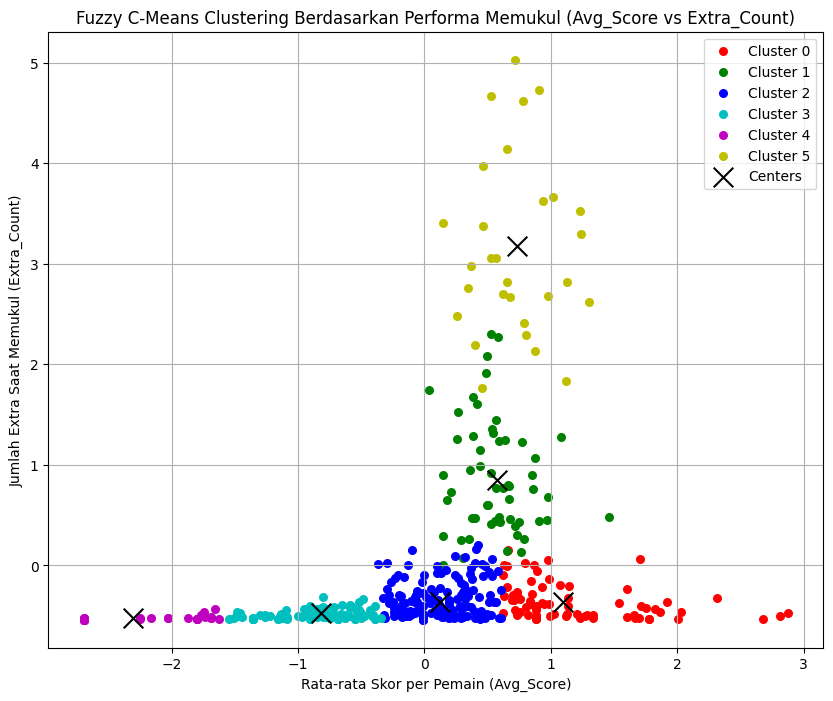

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y']

for j in range(n_clusters):
    plt.scatter(
        data[0, cluster_membership == j],  # Avg_Score
        data[1, cluster_membership == j],  # Extra_Count
        s=30,
        color=colors[j % len(colors)],
        label=f'Cluster {j}'
    )

# Plot centroid
plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', s=200, c='black', label='Centers')

plt.title('Fuzzy C-Means Clustering Berdasarkan Performa Memukul (Avg_Score vs Extra_Count)')
plt.xlabel('Rata-rata Skor per Pemain (Avg_Score)')
plt.ylabel('Jumlah Extra Saat Memukul (Extra_Count)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
!pip install scikit-learn

In [43]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# data.T = data yang dipakai untuk clustering
# cluster_membership = hasil dari np.argmax(u, axis=0)
silhouette = silhouette_score(data.T, cluster_membership)
davies = davies_bouldin_score(data.T, cluster_membership)

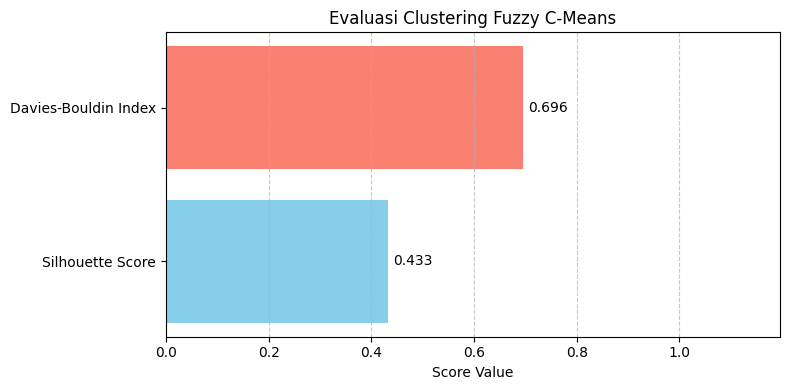

In [44]:
import matplotlib.pyplot as plt

# Simpan skor evaluasi dalam dictionary
evaluation_scores = {
    'Silhouette Score': silhouette,
    'Davies-Bouldin Index': davies
}

# Membuat bar chart horizontal
plt.figure(figsize=(8, 4))
bars = plt.barh(list(evaluation_scores.keys()), list(evaluation_scores.values()), color=['skyblue', 'salmon'])
plt.xlabel('Score Value')
plt.title('Evaluasi Clustering Fuzzy C-Means')

# Tambahkan nilai di ujung bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.3f}', va='center')

plt.xlim(0, max(evaluation_scores.values()) + 0.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()